*Material preparado por Caio Machado para el curso Aplicaciones Matemáticas para Economía y Negocios (solamente para fines didácticos)*

In [1]:
using DifferentialEquations, Parameters, Plots; # Packages que vamos usar
#plotly(); # Uncomment para graficos interactivos

# 1. Modelo base

El modelo presentado es una versión del modelo en Fernandez-Villaverde and Jones (2020) (FJ en lo que sigue). La población total es de $N$ personas, y cada persona puede estar en uno de cinco estados diferentes: *susceptible, infectada, en recuperación, fallecida y recuperada* (las personas se mueven de un estado a otro en este orden, excepto por los últimos dos estados). Tenemos que:


$$ S_{t}+I_{t}+R_{t}+D_{t}+C_{t}=N$$

donde

$$S_{t}=\text{total Susceptibles}$$

$$I_{t}=\text{total Infectados}$$

$$R_{t}=\text{total en Recuperación}$$

$$F_{t}=\text{total Fallecidos}$$

$$C_{t}=\text{total reCuperados}$$

Cada período $t$ representa un día. Usando la notación que $\Delta x_{t+1} = x_{t+1}-x_t$, la evolución del sistema es dada por:

<br />
$$\Delta S_{t+1}=-\underbrace{\beta I_{t} S_{t} / N}_{\text {nuevas infecciones}} \tag{1}$$
<br />
$$\Delta I_{t+1}=\underbrace{\beta I_{t} S_{t} / N}_{\text {nuevas infecciones}}-\underbrace{\gamma I_{t}}_{\text {nuevos en recuperación}} \tag{2}$$
<br />
$$\Delta R_{t+1}=\underbrace{\gamma I_{t}}_{\text {nuevos en recuperación}}-\underbrace{\theta R_{t}}_{\text {nuevos fallecidos o recuperados}} \tag{3}$$
<br />
$$\Delta F_{t+1}=\underbrace{\delta \theta R_{t}}_{\text {nuevos fallecidos}} \tag{4}$$
<br />
$$\Delta C_{t+1}=\underbrace{(1-\delta) \theta R_{t}}_{\text {nuevos recuperados}} \tag{5}$$

La interpretación de los parámetros y ecuaciones es la siguiente:
* Todo día, cada persona infectada ($I_t$) interactúa (por un largo tiempo) en promedio con $\beta$ personas. Una fracción de $S_t/N$ de estas personas son susceptibles a infectarse, y por lo tanto el número total de nuevos infectados es dado por $\beta I_{t} S_{t} / N$. Por ejemplo, si el aislamiento social sube, esto seria representado por un menor valor de $\beta$. Todavía, por ahora vamos a suponer que $\beta$ es constante en el tiempo.

* En cada fecha, una proporción $\gamma$ de los infectados se mueve al estado *en recuperación*. Podemos interpretar irse del estado *infectado* al estado *en recuperación* a entrar en aislamiento total, una vez que uno descubre que tiene Covid. Esta diferenciación entre *infectados* y *en recuperación* puede representar la idea que personas que tienen Covid y saben que tienen Covid infectan menos que personas que no saben que tienen Covid. En particular, estamos suponiendo que personas que saben que tienen el virus se ponen en aislamiento total y no infectan a nadie.

* En cada fecha, una proporción $\theta$ de las personas que están en recuperación dejan este estado, sea por que se han recuperado, sea por que han fallecido.

* Una fracción $\delta$ de las personas que tienen Covid fallecen, y una fracción $(1-\delta)$ se recuperan. 

Percibe que podemos reescribir este sistema como hemos hecho en clase:

$$S_{t+1}=S_t -\beta I_{t} S_{t} / N$$

$$I_{t+1}=I_t + {\beta I_{t} S_{t} / N}-{\gamma I_{t}}$$

$$R_{t+1}=R_t + {\gamma I_{t}}-{\theta R_{t}}$$

$$F_{t+1}=F_t + {\delta \theta R_{t}} $$

$$C_{t+1}=C_t + {(1-\delta) \theta R_{t}} $$

Todavía, Julia nos pide que escribamos el sistema en el formato (1)-(5), pero es el mismo sistema por supuesto. Ahora vamos a representar este sistema dinámico utilizando Julia. Primero, definimos los parámetros del modelo:

In [2]:
@with_kw struct Para
    beta::Float64
    gamma::Float64
    delta::Float64
    theta::Float64
    N::Int64
end;

Los valores específicos de los parámetros vamos a determinar en cada simulación que hagamos más adelante. Ahora definimos las ecuaciones (1)-(5):

In [3]:
function f(du,u,p,t)
    S,I,R,F,C = u
    du[1] = -p.beta*I*S/p.N                   # Ecuación (1)
    du[2] = p.beta*I*S/p.N - p.gamma*I        # Ecuación (2)
    du[3] = p.gamma*I - p.theta*R             # Ecuación (3)
    du[4] = p.delta*p.theta*R                 # Ecuación (4)
    du[5] = (1-p.delta)*p.theta*R             # Ecuación (5)
end;

En todas simulaciones vamos a simular un período de $300$ días (10 meses) y además vamos a suponer que en la fecha inicial había 100 personas infectadas y los demás susceptibles (el caso 100 *confirmado* en Chile ocurrió en mitad de marzo). Representamos la situación inicial por el vector $u_0 = (S_0,I_0,R_0,F_0, C_0)$ abajo. El intervalo de tiempo es representado por $tspan$. Además, vamos siempre usar $N=19$, para representar la población de Chile de aproximadamente 19 millones de personas.

In [4]:
u0 = [19-(100/1e6);100/1e6;0;0;0]  # N está representado en millones, por esto dividimos por 1e6
tspan = (0.0,300.0);

Vamos a armar el problema utilizando la toolbox de Julia *DifferentialEquations.jl* (aunque estamos resolviendo una ecuación en diferencias, podemos usar esta toolbox para resolver problemas en tiempo discreto). Este se puede armar con 4 elementos: (i) Una ley de movimiento (la función $f$); (ii) Un vector de condiciones iniciales $u_0$; (iii) Un intervalo de tiempo para las simulaciones ($tspan$); (iv) parámetros que afectan la función $f$ ($par$). Para armar el problema escribimos `prob = ODEProblem(f,u0,tspan,par)`.  Para resolver el problema escribimos `sol = solve(prob,Euler(),dt=1)`, y así la variable `sol` almacena varias informaciones sobre la solución.

# 2. Simulación del modelo base

Primeramente, precisamos definir los parámetros. No voy a hacer nada muy sofisticado, la idea es solamente elegir algunos parámetros que mínimamente hagan algún sentido. Sigue como he elegido los parámetros:

* $\gamma$: Vamos a seguir FJ y usar $\gamma=0.2$. Esto implica que en promedio, cada persona con Covid permanece en el estado *infectada* por 5 días (hasta pasar para el estado *en recuperación*).

* $\theta$: Vamos a seguir FJ  y usar $\theta=0.1$. Esto implica que cada persona infectada permanece en recuperación por 10 días, en promedio. Por lo tanto, una persona que tiene Covid lleva en promedio 15 días con el virus en nuestro modelo (5 infectada y 10 en recuperación).

* $\delta$: La tasa de mortalidad en Chile está cerca de 1%. Es decir, el número total de fallecidos dividido por el número de casos *confirmados* está cerca de 1%. Todavía, es probable que haya mucha subnotificación de casos, y algunos expertos (en mi Twitter =D) estiman que el número total de casos es 5 veces mayor que el número de casos confirmados. Así que voy a usar $\delta=0.002$

* $\beta$: Por supuesto que $\beta$ varia en el tiempo. Por ejemplo, medidas de cuarentena obligatoria deberían reducir $\beta$. Todavía, estamos suponiendo un $\beta$ constante (vamos a relajar este supuesto más adelante). Podemos tener una idea del valor de $\beta$ mirando datos que dicen cuantas personas los primeros infectados han infectado. Esto es llamado de $\mathcal{R}_0$ y es dado por:

    $$\mathcal{R}_0 = \underbrace{\beta}_{\text{contactos por día}} \times \underbrace{(1/\gamma)}_{\text{promedio días infectado}}$$

    Hay alguna variabilidad en diferentes estimaciones de $\mathcal{R}_0$, pero estas sugieren un número cerca de 2. Así usamos $\mathcal{R}_0=2$ que nos da $\beta=\gamma \mathcal{R}_0=0.4$. 
    
Ahora definimos los valores de los parámetros en Julia para el modelo base:

In [5]:
par = Para(beta = 0.4, gamma = 0.2, delta = 0.002, theta = 0.1, N = 19);

Finalmente podemos armar el problema dado estos parámetros y resolverlo:

In [6]:
prob1 = ODEProblem(f,u0,tspan,par)
sol1 = solve(prob1,Euler(),dt=1);

Y también graficar la solución para los primeros 5 meses:

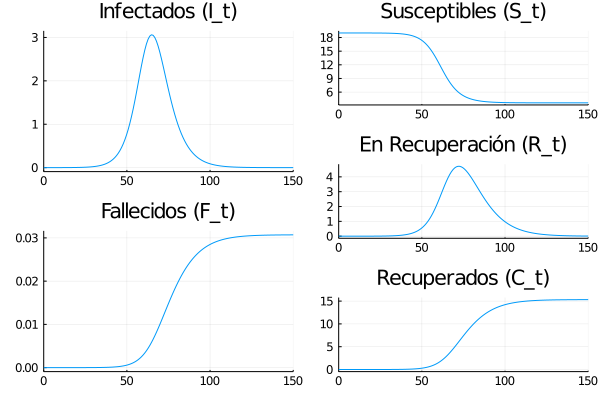

In [7]:
tplot = (0.0,150.0) # Intervalo de tiempo graficado
p1 = plot(sol1,vars=1,tspan = tplot,title="Susceptibles (S_t)")
p2 = plot(sol1,vars=2,tspan = tplot,title="Infectados (I_t)")
p3 = plot(sol1,vars=3,tspan = tplot,title="En Recuperación (R_t)")
p4 = plot(sol1,vars=4,tspan = tplot,title="Fallecidos (F_t)")
p5 = plot(sol1,vars=5,tspan = tplot,title="Recuperados (C_t)")
plot(plot(p2,p4,layout=(2,1)),plot(p1,p3,p5,layout=(3,1)),legend=false,xaxis="")

# 3. Aislamiento social

Suponga que $\beta$ reduce 25%. Esto representa cada persona interactuar con 75% de las personas que interactuaba antes. ¿Qué pasa con la cantidad de fallecidos y la duración de la pandemia? Para contestar esta pregunta, todo que tenemos que hacer es resolver el mismo modelo pero con otro valor de $\beta$.

In [8]:
par2 = reconstruct(par, beta=0.3) # Cambiar parámetros
prob2 = ODEProblem(f,u0,tspan,par2)
sol2 = solve(prob2,Euler(),dt=1);

Ahora vamos graficar la solución con distintos valores de $\beta$ (la línea azul es el $\beta$ usado en el modelo base) para los primeros 8 meses:

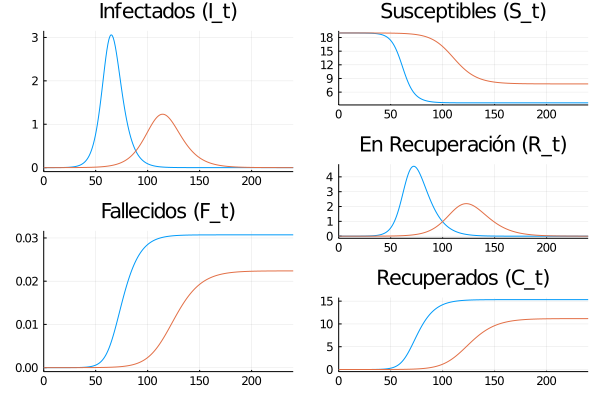

In [9]:
tplot = (0.0,240.0) # Intervalo de tiempo graficado
p1 = plot(sol1,vars=1,tspan=tplot,title="Susceptibles (S_t)")
plot!(sol2,vars=1,tspan=tplot)
p2 = plot(sol1,vars=2,tspan=tplot,title="Infectados (I_t)")
plot!(sol2,vars=2,tspan=tplot)
p3 = plot(sol1,vars=3,tspan=tplot,title="En Recuperación (R_t)")
plot!(sol2,vars=3,tspan=tplot)
p4 = plot(sol1,vars=4,tspan=tplot,title="Fallecidos (F_t)")
plot!(sol2,vars=4,tspan=tplot)
p5 = plot(sol1,vars=5,tspan=tplot,title="Recuperados (C_t)")
plot!(sol2,vars=5,tspan=tplot)
plot(plot(p2,p4,layout=(2,1)),plot(p1,p3,p5,layout=(3,1)),legend=false,xaxis="")

# 4. Aislamiento social "endógeno" I

Ahora vamos a suponer que las personas reaccionan cuando el número de fallecidos $F_t$ sube, quedando más en casa y evitando contacto social. En particular, vamos a suponer que $\beta$ varia en el tiempo y es dado por:

$$\beta_{t+1}=\beta_t+\beta_t\left(1-e^{5F_t}\right)$$

Podemos escribir esta ecuación como

$$\Delta \beta_{t+1} =\beta_t\left(1-e^{5F_t}\right)\tag{6}$$

Perciba que si no hay fallecidos ($F_t=0$) tenemos que $\Delta \beta_t = 0$, o sea, $\beta_t$ no cambia. A medida que sube el número de fallecidos las personas empiezan a cambiar su comportamiento y reducir el contacto con otras personas. Ahora, nuestro sistema dinámico es dado por ecuaciones (1)-(5) del modelo base (con $\beta$ reemplazado por $\beta_t$) más ecuación (6). Precisamos entonces reescribir la ley de movimiento para usar en Julia: 

In [10]:
function f3(du,u,p,t)
    S,I,R,F,C,betad = u
    du[1] = -betad*I*S/p.N                   # Ecuación (1)
    du[2] = betad*I*S/p.N - p.gamma*I        # Ecuación (2)
    du[3] = p.gamma*I - p.theta*R            # Ecuación (3)
    du[4] = p.delta*p.theta*R                # Ecuación (4)
    du[5] = (1-p.delta)*p.theta*R            # Ecuación (5)
    du[6] = betad*(1-exp(5*F))               # Ecuación (6)
end;

También necesitamos ajustar el vector de condiciones iniciales, que ahora debe incluir un valor para $\beta$. Vamos a suponer que en el período $t=0$, $\beta=0.4$ (el mismo valor que usamos el modelo base):

In [11]:
u03 = [u0; par.beta];

Finalmente podemos definir y resolver en Julia el problema nuevo:

In [12]:
prob3 = ODEProblem(f3,u03,tspan,par)
sol3 = solve(prob3,Euler(),dt=1);

Y ahora graficamos la solución para los primeros 5 meses:

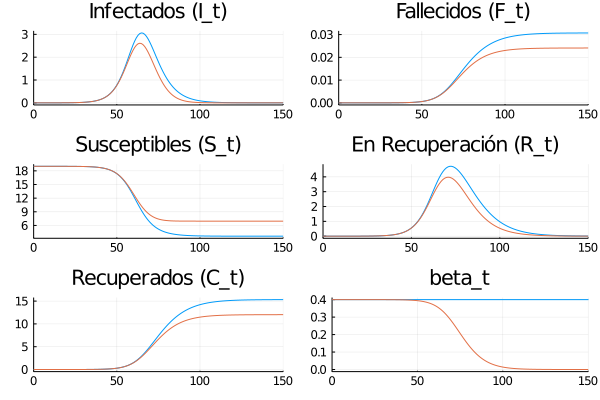

In [13]:
tplot = (0.0,150.0) # Intervalo de tiempo graficado
p1 = plot(sol1,vars=1,tspan=tplot,title="Susceptibles (S_t)")
plot!(sol3,vars=1,tspan=tplot)
p2 = plot(sol1,vars=2,tspan=tplot,title="Infectados (I_t)")
plot!(sol3,vars=2,tspan=tplot)
p3 = plot(sol1,vars=3,tspan=tplot,title="En Recuperación (R_t)")
plot!(sol3,vars=3,tspan=tplot)
p4 = plot(sol1,vars=4,tspan=tplot,title="Fallecidos (F_t)")
plot!(sol3,vars=4,tspan=tplot)
p5 = plot(sol1,vars=5,tspan=tplot,title="Recuperados (C_t)")
plot!(sol3,vars=5,tspan=tplot)
p6 = plot(sol3.t,0*sol3.t.+par.beta,title="beta_t",tspan=tplot)
plot!(sol3,vars=6,tspan=tplot)
plot(p2,p4,p1,p3,p5,p6,layout=(3,2),legend=false,xaxis="")

# 5. Aislamiento social "endógeno" II

En el modelo anterior, hemos supuesto que las personas reducen contacto con otros de acuerdo al número total de fallecidos. Esto implicaba que cuando terminaba la pandemia, el contacto social aún quedaba más bajo. Ahora vamos a suponer que las personas reaccionan *a las personas fallecidas en el día anterior*. Queremos suponer también que a medida que el número de fallecidos diarios empieza a caer, las personas pasan a tener más contacto social, aunque el nivel de muertos aun sea alto. Vamos a suponer que $\beta_t$ es la siguiente función de los nuevos fallecidos $F_t-F_{t-1}$:

$$\beta_{t+1}=\beta_t+\beta_t\left(1-e^{500\overbrace{(F_t-F_{t-1})}^{\text{nuevos fallecidos}}}-(\beta_t-0.4)\right) \tag{7}$$

El término $(\beta_t-0.4)$ hace con que si nadie más fallece de Covid, $\beta$ converge a su valor de 0.4 pre-pandemia. Perciba que ahora tenemos un sistema de orden 2, pues $F_{t-1}$ aparece en ecuación (7). Para transformarlo en un sistema de orden 1 definimos una variable auxiliar $z_t=F_{t-1}$ y adicionamos la siguiente ecuación al sistema:

$$z_{t+1}=F_t \tag{8}$$

Que podemos escribir como $\Delta z_{t+1} = F_t-z_t$ (restando $z_t$ de los dos lados). Por lo tanto escribimos el sistema con ecuaciones (1)-(5) más ecuaciones (7) y (8) en Julia:

In [14]:
function f4(du,u,p,t)
    S,I,R,F,C,betad, z = u
    du[1] = -betad*I*S/p.N                           # Ecuación (1)
    du[2] = betad*I*S/p.N - p.gamma*I                # Ecuación (2)
    du[3] = p.gamma*I - p.theta*R                    # Ecuación (3)
    du[4] = p.delta*p.theta*R                        # Ecuación (4)
    du[5] = (1-p.delta)*p.theta*R                    # Ecuación (5)
    du[6] = betad*(1-exp(500*(F-z))-(betad-0.4))     # Ecuación (7)
    du[7] = F-z                                      # Variable auxiliar para reducir orden del sistema
end;

También necesitamos ajustar el vector de condiciones iniciales, que ahora debe incluir un valor para $\beta$ y para $z$. Vamos a suponer que en el período $t=0$, $\beta=0.4$ como antes. Además, vamos a suponer que $z_0=0$ (no hubo fallecidos en $t=-1$):

In [15]:
u04 = [u0; par.beta;0];

Finalmente podemos definir y resolver en Julia el problema nuevo:

In [16]:
prob4 = ODEProblem(f4,u04,tspan,par)
sol4 = solve(prob4,Euler(),dt=1);

Y ahora graficamos la solución para los primeros 10 meses:

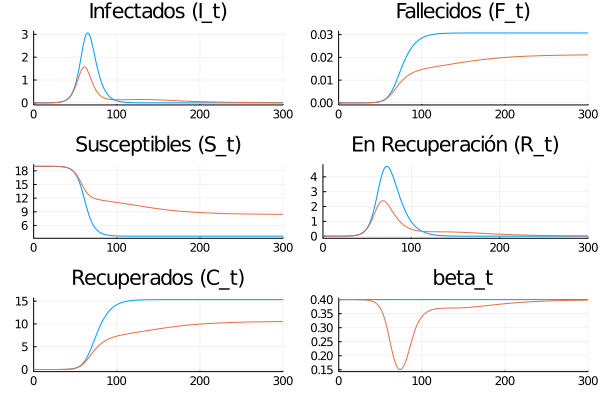

In [17]:
tplot = (0.0,300.0) # Intervalo de tiempo graficado
p1 = plot(sol1,vars=1,tspan=tplot,title="Susceptibles (S_t)")
plot!(sol4,vars=1,tspan=tplot)
p2 = plot(sol1,vars=2,tspan=tplot,title="Infectados (I_t)")
plot!(sol4,vars=2,tspan=tplot)
p3 = plot(sol1,vars=3,tspan=tplot,title="En Recuperación (R_t)")
plot!(sol4,vars=3,tspan=tplot)
p4 = plot(sol1,vars=4,tspan=tplot,title="Fallecidos (F_t)")
plot!(sol4,vars=4,tspan=tplot)
p5 = plot(sol1,vars=5,tspan=tplot,title="Recuperados (C_t)")
plot!(sol4,vars=5,tspan=tplot)
p6 = plot(sol4.t,0*sol4.t.+par.beta,tspan=tplot,title="beta_t")
plot!(sol4,vars=6,tspan=tplot)
plot(p2,p4,p1,p3,p5,p6,layout=(3,2),legend=false,xaxis="")

# 6. Cuarentena obligatoria temporaria

Ahora vamos a suponer que el gobierno impone una cuarentena obligatoria 50 días después de que haya empezado la pandemia. Todavía, 30 días después esta cuarentena termina. Vamos a suponer que el $\beta$ sin cuarentena es 0.4 y el $\beta$ con cuarentena es $0.15$:

$$\beta_{t}=\begin{cases}
0.4 & \text{ si }t\leq50\text{ o }t\geq80\\
0.15 & \text{ si }t\in\left(50,80\right)
\end{cases}$$

Esta es la reducción aproximada que deberíamos esperar si 62,5% de las personas se pone en aislamiento total en su casa, con cero interacciones, y los demás siguen trabajando normalmente (por ejemplo, por que trabajan en servicios esenciales). Tenemos que definir esta función para $\beta$ en Julia. Hagámoslo de manera general para una cuarentena que empieza en una fecha $tstart$ y termina $d$ días después:

In [18]:
function beta_cuarentena(t,tstart,d)
    if t<=tstart||t>=tstart+d
        out = 0.4
    else
        out = 0.15
    end
end;

Y ahora podemos definir la ley de movimiento como hicimos antes:

In [19]:
function f5(du,u,p,t)
    S,I,R,F,C,betad = u
    du[1] = -betad*I*S/p.N                   # Ecuación (1)
    du[2] = betad*I*S/p.N - p.gamma*I        # Ecuación (2)
    du[3] = p.gamma*I - p.theta*R            # Ecuación (3)
    du[4] = p.delta*p.theta*R                # Ecuación (4)
    du[5] = (1-p.delta)*p.theta*R            # Ecuación (5)
    du[6] = beta_cuarentena(t,50,30)-betad   # Ecuación para beta con cuarentena (tstart=50, d=30)
end;

Las condiciones iniciales son como antes:

In [20]:
u05 = [u0; par.beta];

El problema y la solución en Julia son dados por:

In [21]:
prob5 = ODEProblem(f5,u05,tspan,par)
sol5 = solve(prob5,Euler(),dt=1);

Y una vez más, graficamos todo para los primeros 7 meses:

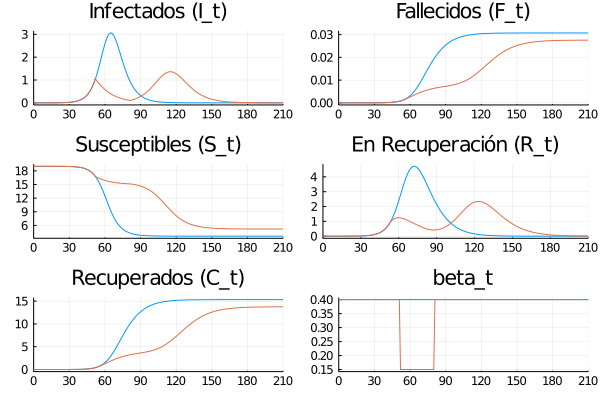

In [22]:
tplot = (0.0,210.0) # Intervalo de tiempo graficado
p1 = plot(sol1,vars=1,tspan=tplot,title="Susceptibles (S_t)")
plot!(sol5,vars=1,tspan=tplot)
p2 = plot(sol1,vars=2,tspan=tplot,title="Infectados (I_t)")
plot!(sol5,vars=2,tspan=tplot)
p3 = plot(sol1,vars=3,tspan=tplot,title="En Recuperación (R_t)")
plot!(sol5,vars=3,tspan=tplot)
p4 = plot(sol1,vars=4,tspan=tplot,title="Fallecidos (F_t)")
plot!(sol5,vars=4,tspan=tplot)
p5 = plot(sol1,vars=5,tspan=tplot,title="Recuperados (C_t)")
plot!(sol5,vars=5,tspan=tplot)
p6 = plot(sol5.t,0*sol5.t.+par.beta,tspan=tplot,title="beta_t")
plot!(sol5,vars=6,tspan=tplot,denseplot=false)
plot(p2,p4,p1,p3,p5,p6,layout=(3,2),legend=false,xaxis="")

¿Y si la cuarentena obligatoria empieza antes? ¿Tendremos menos fallecidos de acuerdo con este modelo? Suponga ahora que la cuarentena dura lo mismo pero parte 30 días antes:

$$\beta_{t}=\begin{cases}
0.4 & \text{ si }t\leq20\text{ o }t\geq50\\
0.15 & \text{ si }t\in\left(20,50\right)
\end{cases}$$

Repitiendo los mismos pasos que antes en Julia:

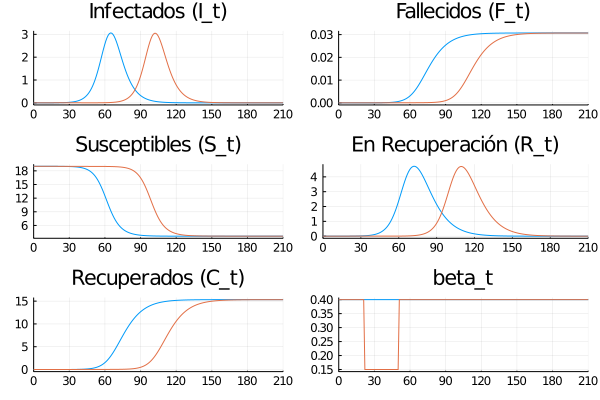

In [23]:
function f6(du,u,p,t)
    S,I,R,F,C,betad = u
    du[1] = -betad*I*S/p.N                   # Ecuación (1)
    du[2] = betad*I*S/p.N - p.gamma*I        # Ecuación (2)
    du[3] = p.gamma*I - p.theta*R            # Ecuación (3)
    du[4] = p.delta*p.theta*R                # Ecuación (4)
    du[5] = (1-p.delta)*p.theta*R            # Ecuación (5)
    du[6] = beta_cuarentena(t,20,30)-betad   # Ecuación para beta con cuarentena (tstart=20, d=30)
end;

u06 = [u0; par.beta];

prob6 = ODEProblem(f6,u06,tspan,par)
sol6 = solve(prob6,Euler(),dt=1);

tplot = (0.0,210.0) # Intervalo de tiempo graficado
p1 = plot(sol1,vars=1,tspan=tplot,title="Susceptibles (S_t)")
plot!(sol6,vars=1,tspan=tplot)
p2 = plot(sol1,vars=2,tspan=tplot,title="Infectados (I_t)")
plot!(sol6,vars=2,tspan=tplot)
p3 = plot(sol1,vars=3,tspan=tplot,title="En Recuperación (R_t)")
plot!(sol6,vars=3,tspan=tplot)
p4 = plot(sol1,vars=4,tspan=tplot,title="Fallecidos (F_t)")
plot!(sol6,vars=4,tspan=tplot)
p5 = plot(sol1,vars=5,tspan=tplot,title="Recuperados (C_t)")
plot!(sol6,vars=5,tspan=tplot)
p6 = plot(sol6.t,0*sol6.t.+par.beta,tspan=tplot,title="beta_t")
plot!(sol6,vars=6,tspan=tplot,denseplot=false)
plot(p2,p4,p1,p3,p5,p6,layout=(3,2),legend=false,xaxis="")

# 7. Timing óptimo de cuarentena temporaria

Suponga ahora que un planificador puede hacer una cuarentena temporaria de 30 días como la presentada anteriormente y quiere elegir la fecha óptima para empezarla. El objetivo es reducir el número de fallecidos el máximo posible. Podemos simular este modelo varias veces con diferentes fechas iniciales para la cuarentena y ver cual lleva a un menor número total de fallecidos al final de la pandemia. Esto es implementado abajo:

In [24]:
u07 = [u0; par.beta];
tspan7 = (0,1000) # Fecha final de simulación tiene que ser larga ahora, para garantizar siempre fin de la pandemia
fallecidos = Array{Float64}(undef, 121)

for i=0:120
    function f7(du,u,p,t)
        S,I,R,F,C,betad = u
        du[1] = -betad*I*S/p.N                   # Ecuación (1)
        du[2] = betad*I*S/p.N - p.gamma*I        # Ecuación (2)
        du[3] = p.gamma*I - p.theta*R            # Ecuación (3)
        du[4] = p.delta*p.theta*R                # Ecuación (4)
        du[5] = (1-p.delta)*p.theta*R            # Ecuación (5)
        du[6] = beta_cuarentena(t,i,30)-betad    # Ecuación para beta con cuarentena (tstart=i, d=30)
    end;

    prob7 = ODEProblem(f7,u07,tspan7,par)
    sol7 = solve(prob7,Euler(),dt=1)
    fallecidos[i+1] = last(sol7[4,:]) # Almacena fallecidos para cada fecha inicial i
end

Ahora podemos graficar como el número de fallecidos al final de la pandemia depende de la fecha inicial de la cuarentena:

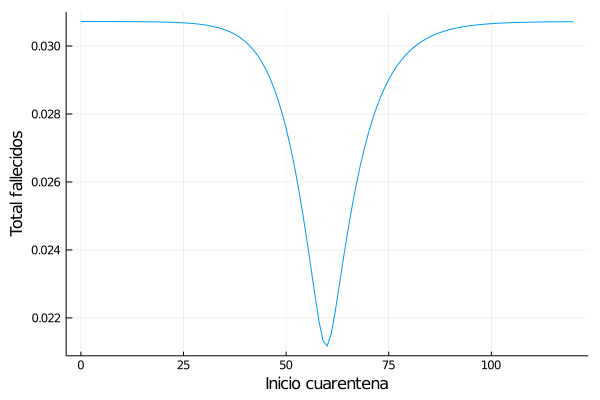

In [25]:
plot([0:120],fallecidos,ylabel="Total fallecidos",xlabel="Inicio cuarentena",legend=false)